## 範例重點

* 知道如何設定監控目標
* 學習如何在 Keras 中加入 reduce learning rate
* 比較有無降低學習率時的表現

In [1]:
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model, load_model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
class Trainer:

    def __init__(self, X_train, y_train, X_test, y_test, build_param, neuron_numbers=(512, 256, 128,),
                 epochs=50, batch_size=1024, learning_rate=1e-3):
        self.X_test = X_test
        self.y_test = y_test
        self.X_train = X_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.neuron_numbers = neuron_numbers
        self.build_param = build_param
        self._model = None
        self._history = None

    @property
    def optimizer(self):
        clz, param = self.build_param.optimizer_clz, self.build_param.optimizer_param
        return clz(lr=self.learning_rate, **param)

    @property
    def callbacks(self):
        factor, patience = self.build_param.rlrop_factor, self.build_param.rlrop_patience
        return [ReduceLROnPlateau(factor=factor, patience=patience, min_lr=1e-12, verbose=1)]

    @property
    def validation_data(self):
        return (self.X_test, self.y_test,)

    def run(self):
        return self._clear()._build()._launch()

    def _clear(self):
        backend.clear_session()
        self._model = None
        return self

    def _build(self):
        main_input = hidden_input = Input(shape=self.X_train.shape[-1:], name='main_input')
        for i, neuron_number in enumerate(self.neuron_numbers):
            hidden_input = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}')(hidden_input)
            hidden_input = BatchNormalization()(hidden_input)
        main_output = Dense(units=self.y_train.shape[-1], activation='softmax', name='main_output')(hidden_input)
        self._model = Model(inputs=[main_input], outputs=[main_output])
        self._model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return self

    def _launch(self):
        print('Experiment with label: {}'.format(self.build_param.label))
        self._model.summary()
        self._history = self._model.fit(
            self.X_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size,
            validation_data=self.validation_data, callbacks=self.callbacks, shuffle=True, verbose=2)
        return self

    def display(self, train_name, val_name, color):
        plt.plot(self._history.history[train_name], '-', label='exp: {}'.format(self.build_param.label), color=color)
        plt.plot(self._history.history[val_name], '--', label='exp: {}'.format(self.build_param.label), color=color)

class BuildParam:

    def __init__(self, optimizer_clz, optimizer_param, rlrop_factor, rlrop_patience):
        self.optimizer_clz = optimizer_clz
        self.optimizer_param = optimizer_param
        self.rlrop_factor = rlrop_factor
        self.rlrop_patience = rlrop_patience

    @property
    def label(self):
        return 'op={}, ft={:.2f}, pt={}'.format(self.optimizer_clz.__name__.lower(), self.rlrop_factor, self.rlrop_patience)

class BatchTrainer:
    
    def __init__(self, trainers, build_params):
        self.trainers = trainers
        self.build_params = build_params
        self.total_amount = len(trainers)

    @property
    def colors(self):
        color_map = cm.ScalarMappable(cmap=plt.get_cmap('gist_rainbow'),
                                      norm=colors.Normalize(vmin=0, vmax=self.total_amount - 1))
        return [color_map.to_rgba(i) for i in range(self.total_amount)]

    def run(self):
        for i in range(self.total_amount):
            self.trainers[i].run()
        return self

    def display(self, train_name, val_name):
        plt.figure(figsize=(12, 7,))
        for i, color in enumerate(self.colors):
            self.trainers[i].display(train_name, val_name, color)
        plt.xlabel('Epoch')
        plt.ylabel(train_name)
        plt.title('Train History')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5,))
        plt.show()

## 訓練模型

In [7]:
# 設定超參數
optimizers = [(SGD, {'momentum': 0.95, 'nesterov': True},)]
rlrop_factors = [0.5]
rlrop_patiences = [5]

params = [BuildParam(*optimizer, rlrop_factor, rlrop_patience) for optimizer, rlrop_factor, rlrop_patience
          in itertools.product(optimizers, rlrop_factors, rlrop_patiences)]
trainers = [Trainer(X_train, y_train, X_test, y_test, param) for param in params]

In [8]:
batch_trainer = BatchTrainer(trainers, params).run()

Experiment with label: op=sgd, ft=0.50, pt=5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (N

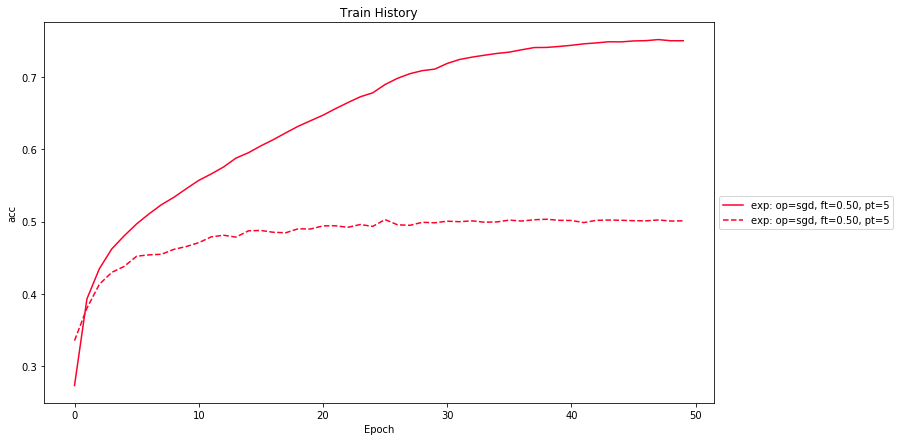

In [9]:
batch_trainer.display('acc', 'val_acc')

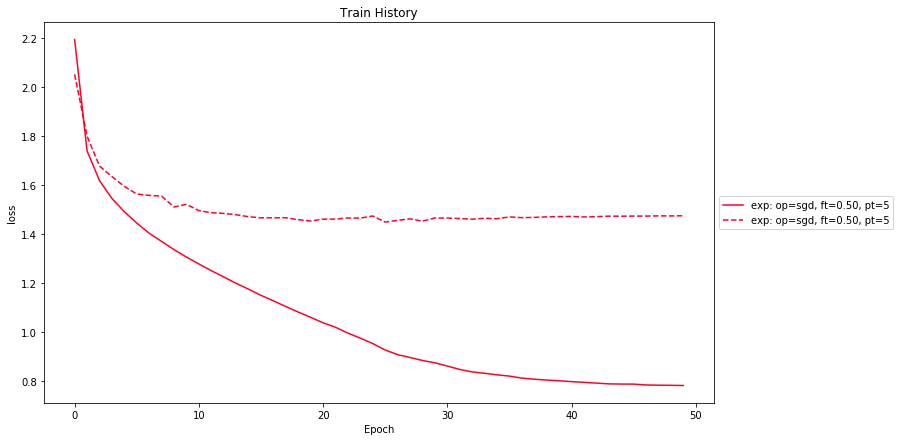

In [10]:
batch_trainer.display('loss', 'val_loss')

## 作業

1. 請改變 reduce learning rate 不同的 patience 和 factor，並比較對訓練集/驗證集的影響。
2. 請改變 optimizer 換成 Adam 和 RMSprop ，並搭配 reduce learning rate 不同的 patience 和 factor，並比較對訓練集/驗證集的影響。